This notebook investigate several strategies to assess how to select hyperparameters for tikhonet.

In [1]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize']=[12,8]

In [2]:
matplotlib.rcParams['figure.figsize']=[12,8]

In [12]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
"""
Based on code written by alechat
"""

import os
import numpy as np
from subprocess import Popen, PIPE

def fits2npy(fits_file, idx_hdu):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//96
    data_list = []
    idx_list = range(0, 10000)
    for i in idx_list:
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        data_list.append(data[x:x+96,y:y+96])
    return np.asarray(data_list)

def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err

def generate_shape_txt(gal_file, psf_file, output_file, gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    print('Computing ellipticity for file: %s'%(gal_file))
    print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s | tee %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s | tee %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    cmd_file = 'get_shape.cmd'
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

def get_target_shape(gal_file, output_file, idx=4):
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    images = fits.getdata(gal_file, idx)
    psfs = fits.getdata(gal_file, 3)
    fits.writeto(tmp_file, images)
    fits.writeto(tmp_psf_file, psfs)
    stdout, stderr = generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    return stdout, stderr

def get_ellipticity(file_name):
    ellip = []
    with open(file_name, 'r') as f:
        data = f.readlines()
    for l in data:
        ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
    return np.asarray(ellip)

def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err


def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2ac0b3cef0>,
 <matplotlib.colorbar.Colorbar at 0x7f2ac0ac3940>)

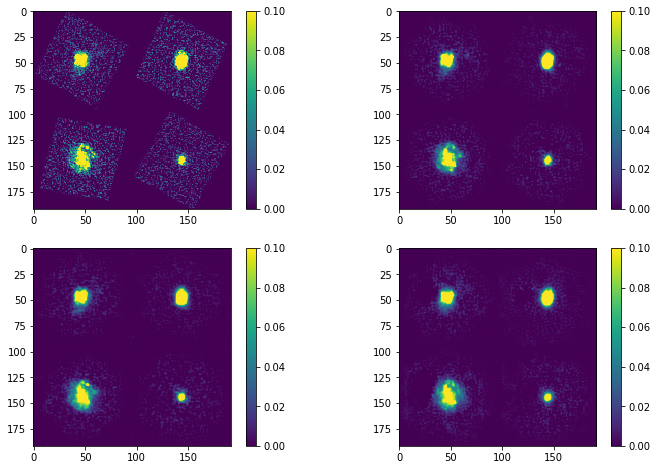

In [14]:
#Explore various results:
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
testset_file = 'image-shfl-0-multihdu.fits'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
SNR=100
target=fits.getdata(write_path+'images/'+target_name)
unet4x4x4_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4=fits.getdata(unet4x4x4_name)
unet4x4x4_res_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4_res=fits.getdata(unet4x4x4_res_name)
deconvnet_name=write_path+"images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
deconvnet=fits.getdata(deconvnet_name)

plt.subplot(2,2,1),plt.imshow(target[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,2),plt.imshow(unet4x4x4[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,3),plt.imshow(unet4x4x4_res[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,4),plt.imshow(deconvnet[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()


Check which code Alexis was using from skimage

In [15]:
from skimage import restoration
import copy
def dirac2d(ndim,shape,is_real=True):
    impr = np.zeros([3] * ndim)
    impr[(slice(1, 2), ) * ndim] = 1.0 
    return restoration.uft.ir2tf(impr, shape, is_real=is_real), impr

def correct_pixel_window_function(fpsf, size_img):
    """
    Correct for pixel window effect (beware of aliasing)
    This is useful for convolution with band limited signal sampled higher than Nyquist frequency,
    to better approximate continuous convolution followed by sampling with discrete convolution.
    @param fpsf fourier transform to be corrected for sampling effect
    @param size_img size of input image (to check if real or complex transform)
    @return the fourier transform with extra phase (same size as fpsf)
    """
    mult_x=np.array(np.fft.fftfreq(size_img[0]),dtype=np.float64)
    if fpsf.shape[1] != size_img[1]:
        mult_y=np.array(np.fft.rfftfreq(size_img[1]),dtype=np.float64)
    else:
        mult_y=np.array(np.fft.fftfreq(size_img[1]),dtype=np.float64)
    pwf_x=np.array([np.sinc(kx) for kx in mult_x],dtype=np.float64)
    pwf_y=np.array([np.sinc(ky) for ky in mult_y],dtype=np.float64)
    return copy.deepcopy(fpsf / np.outer(pwf_x, pwf_y))

def perform_shift_in_frequency(fpsf, size_img, shift):
    """
    Add phase to fourier transform to shift signal centered in *shift* to 0
    @param fpsf fourier transform needing extra phase factor
    @param size_img size of input image (to check if real or complex transform)
    @param shift, shift in [x,y] for array[x,y]
    @return the fourier transform with extra phase (same size as fpsf)
    """
    phase_factor= np.float64(2. * np.pi) * shift.astype(np.float64)
    if phase_factor[0] ==0.:
        kx_ft=np.zeros(size_img[0])+1.
    else :
        kx_ft=np.exp(np.fft.fftfreq(size_img[0],d=1./phase_factor[0])*1j)
    if phase_factor[1] ==0.:
        ky_ft=np.zeros(fpsf.shape[1],dtype=np.float64)+1.
    else:
        if fpsf.shape[1] != size_img[1]:
            ky_ft=np.exp(np.fft.rfftfreq(size_img[1],d=1./phase_factor[1])*1j)
        else:
            ky_ft=np.exp(np.fft.fftfreq(size_img[1],d=1./phase_factor[1])*1j)
    return copy.deepcopy(np.outer(kx_ft,ky_ft)*fpsf)

def recenter_psf(psf,param):
    fpsf=np.fft.fft2(psf)
    fpsf_ctr=perform_shift_in_frequency(fpsf, psf.shape, param)
    return np.real(np.fft.ifft2(fpsf_ctr))
    

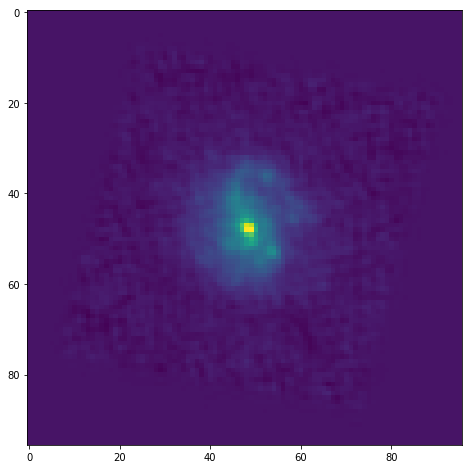

In [16]:
from skimage import restoration
data_path='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
#ref=(slice(96,192),slice(96,192)) #for centering
ref=(slice(96,192),slice(0,96)) #for spiral
image=fits.getdata(data_path+testset_file,0)[ref]
psf=fits.getdata(data_path+testset_file,1)[ref]
target=fits.getdata(data_path+testset_file,2)[ref]
psf_ctr=recenter_psf(psf,np.array([-0.5,-0.5]))
psf_tar=fits.getdata('/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits')
plt.imshow(image)

In [19]:
import scipy.signal
from DeepDeconv.utils.deconv_utils import FISTA,tikhonov
from DeepDeconv.utils.data_utils import add_noise
np.random.seed(0)
SNR_SIMU=20
noisy_im,SNR_list,sigma_list=add_noise(image,SNR=SNR_SIMU)
yf=restoration.uft.ufft2(noisy_im)
trans_func = restoration.uft.ir2tf(psf_ctr, image.shape, is_real=False)
deconv_im0=np.real(restoration.wiener(noisy_im,trans_func,1/SNR_list[0], is_real=False,clip=False))
#Here I ensure that we get minimal (isotropic) residual when the shift is [-0.5,-0.5]. Note that the target is itself convolved with a gaussian FWHM=0.07 PSF
#for kval in np.arange(-1,1.1,0.1):
#    psf_ctr=recenter_psf(psf,np.array([kval,kval]))
#    trans_func = restoration.uft.ir2tf(psf_ctr, image.shape, is_real=False)
#    deconv_im0=np.real(restoration.wiener(noisy_im,trans_func,1/SNR_list[0], is_real=False,clip=False))
#    print(kval,np.linalg.norm(target-deconv_im0)**2)
#plt.figure()
#plt.imshow(target-deconv_im0),plt.colorbar()
#print(np.linalg.norm(target-deconv_im0)**2)

Laplacian


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2ac086fd68>)

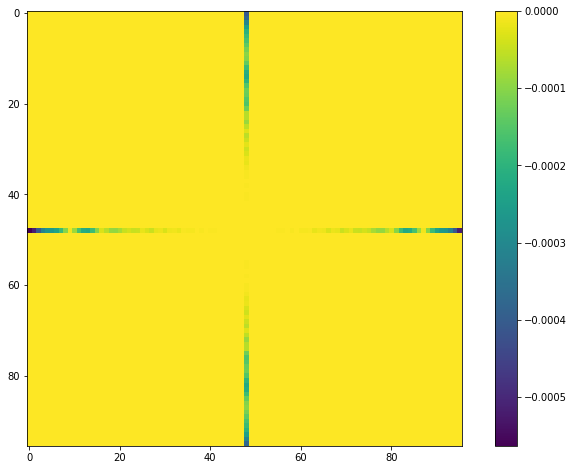

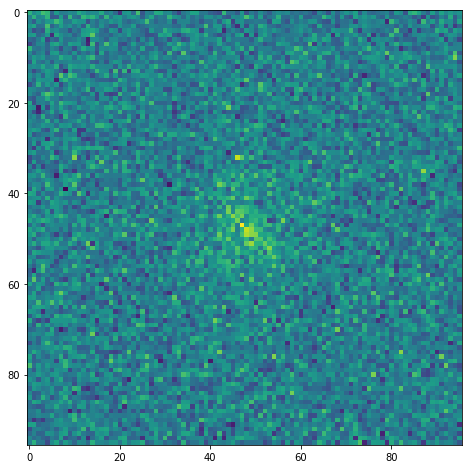

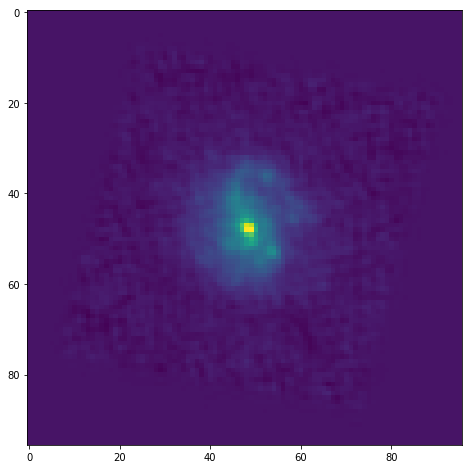

In [20]:
tfdirac,imdirac=dirac2d(noisy_im.ndim,noisy_im.shape,is_real=False)
lap_tf, lap_ker = restoration.uft.laplacian(image.ndim, image.shape, is_real=False)
fullh=np.abs(trans_func)
lst_nonz=np.where(fullh>0)
plt.imshow(np.abs(trans_func)-np.abs(restoration.uft.ufft2(psf))*96),plt.colorbar()
plt.figure(),plt.imshow(noisy_im)
plt.figure(),plt.imshow(image)

0.09979699552059171 
 0.09979699552059174 

 [[0.03179583 0.04312509 0.01788405]
 [0.07005542 0.099797   0.05226746]
 [0.0525772  0.07484671 0.03847468]]


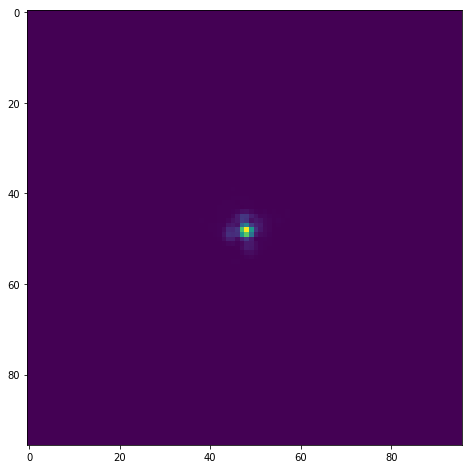

In [21]:
psfT = restoration.uft.uifft2(np.conj(restoration.uft.ufft2(psf)))
plt.imshow(np.abs(psfT))
print(np.abs(psfT[48,48]),'\n',psf[48,48],'\n\n',np.rot90(psf, k=2, axes=(0, 1))[46:49,46:49])


In short, the transpose of the array is the rotated kernel by 180 degrees around [48,48], which does not correspond to its rotation by 180 degrees in the numpy routine.

### Check normalization

In [22]:
ts2=np.abs(restoration.uft.ufft2(np.random.randn(96,96)*sigma_list[0])[lst_nonz])**2

np.mean(ts2),sigma_list[0]**2,np.std(np.random.randn(96,96)*sigma_list[0])**2

(0.010137922201220414, 0.010319365555399902, 0.010261502607450658)

 OK, everything is consistant in terms of noise energy

### Check Wiener

In [23]:
hyp_param=1.0/(SNR_list[0]) #Choice of Alexis (incorrect)
print(hyp_param)

0.05


#### SKimage implementation

In [24]:
skimage_tikho=restoration.wiener(noisy_im,trans_func,hyp_param,reg=tfdirac, is_real=False,clip=False)
skimage_wiener=restoration.wiener(noisy_im,trans_func,hyp_param,reg=lap_tf, is_real=False,clip=False)

#### Manual implementation of Hunt/Tikhonov deconv

In [25]:
def manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param):
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
    yf=restoration.uft.ufft2(noisy_im)
    sol=np.real(restoration.uft.uifft2(filter_f*yf))
    return sol

In [26]:
hfstar=np.conj(trans_func)
h2=np.abs(trans_func)**2
d2=np.abs(tfdirac)**2
tikho_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
wiener_f=hfstar/(h2+hyp_param*np.abs(lap_tf)**2)#/SNR_list[0]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2ac07b2860>,
 Text(0.5, 1.0, 'Wiener_skim-Wiener_manual'))

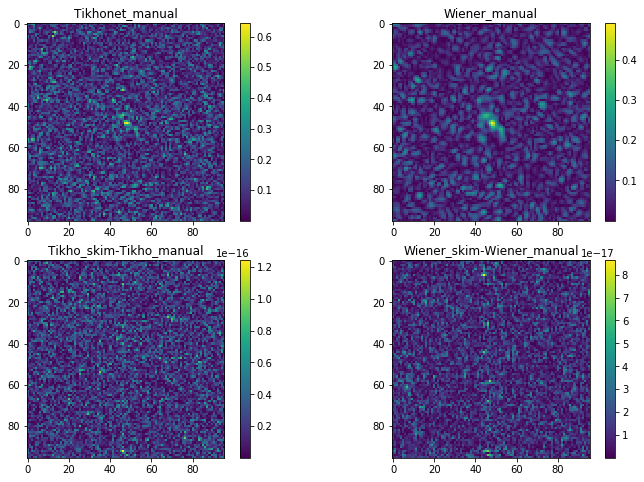

In [27]:
sol_tik=manual_deconv_l2(noisy_im,trans_func,tfdirac,hyp_param)
sol_wien=manual_deconv_l2(noisy_im,trans_func,lap_tf,hyp_param)
plt.figure()
plt.subplot(221),plt.imshow(np.abs(sol_tik)),plt.colorbar(),plt.title('Tikhonet_manual')
plt.subplot(222),plt.imshow(np.abs(sol_wien)),plt.colorbar(),plt.title('Wiener_manual')
plt.subplot(223),plt.imshow(np.abs(sol_tik-skimage_tikho)),plt.colorbar(),plt.title('Tikho_skim-Tikho_manual')
plt.subplot(224),plt.imshow(np.abs(sol_wien-skimage_wiener)),plt.colorbar(),plt.title('Wiener_skim-Wiener_manual')

In ccl: psf needs to be corrected as transfer function, effectively multiplying its Fourier transform  by sqrt(nrows*ncols).

Laplacian kernel is used by default


In [51]:
check_hyper=10**np.arange(-5.0,2.5,0.001)

### Check SURE

#### Set up useful variables in fourier space

In [52]:
h2=np.abs(trans_func)**2 #This is |h_w|^2
l2=np.abs(lap_tf)**2 #This is |l_w|^2 in case of laplacian
d2=np.abs(tfdirac)**2 #This is 1 (tikhonov:Dirac kernel)
y2z=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image

h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(tfdirac[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im)[lst_nonz])**2 #This is the FFT of noisy image

(<matplotlib.image.AxesImage at 0x7f2ab2cfac50>,
 <matplotlib.colorbar.Colorbar at 0x7f2ab2ca8278>)

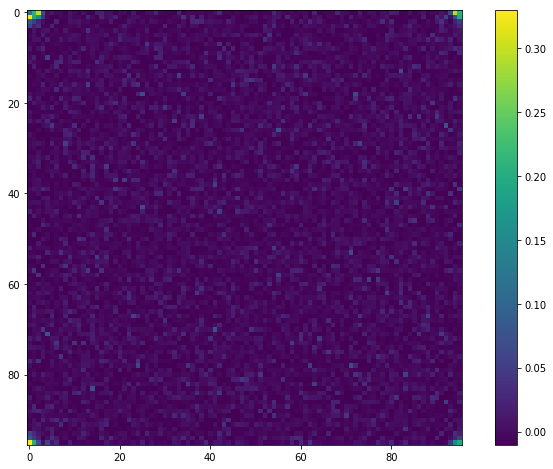

In [53]:
plt.imshow(y2z-sigma_list[0]**2),plt.colorbar()

#### SURE estimation risk

4.988844874621981 168.65530253981137 0.05 -4.150979247055821


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2ab2b35550>,
 Text(0.5, 1.0, 'Wiener Proj SURE'))

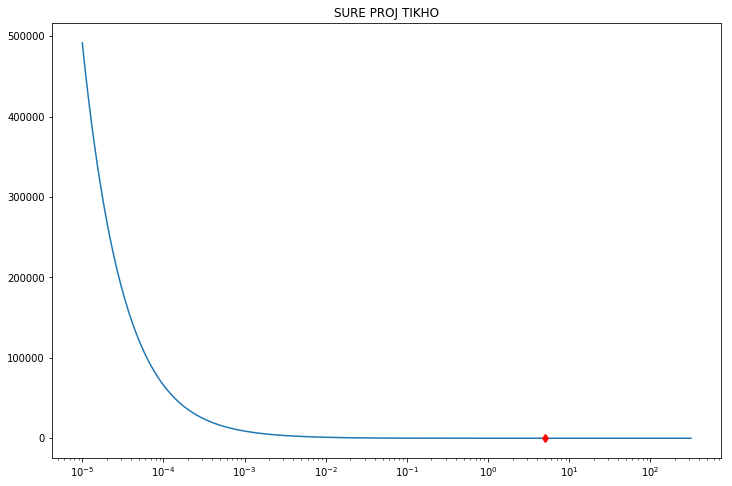

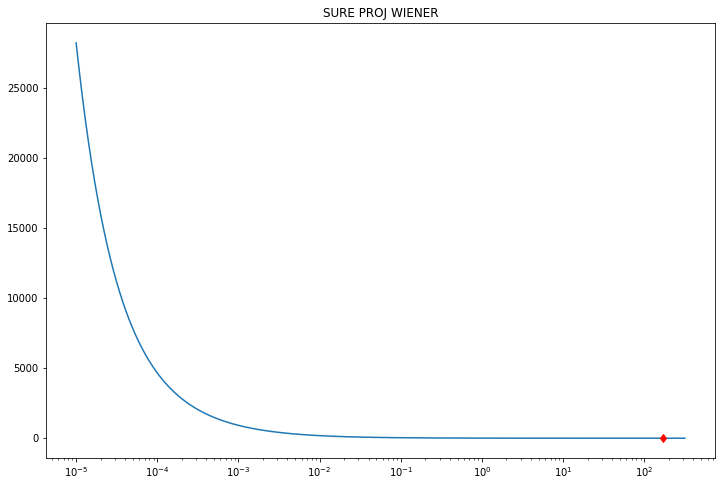

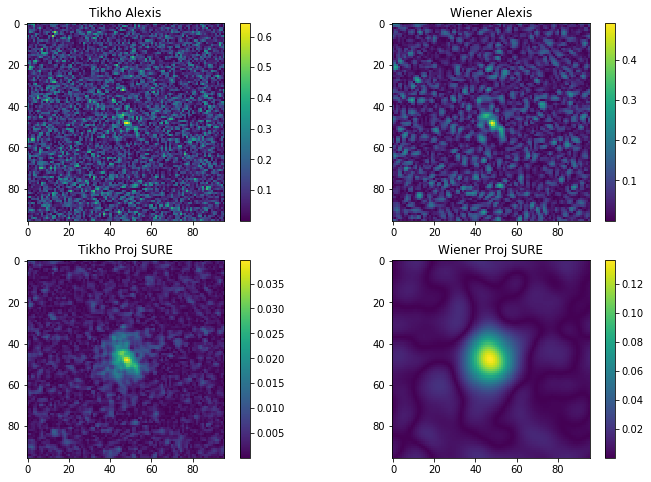

In [54]:
def proj_sure(h2,y2,x,reg2,sigma2):
    den=h2+x*reg2
    den2=den**2
    return np.sum(h2*y2/den2+2.0*(sigma2-y2)/den)

res_sure_proj_tikho=np.array([[x,proj_sure(h2_nonz,y2_nonz,x,d2_nonz,sigma_list[0]**2)] for x in check_hyper])
tau_sure_proj_tikho=res_sure_proj_tikho[np.argmin(res_sure_proj_tikho[:,1])][0]

res_sure_proj_wiener=np.array([[x,proj_sure(h2_nonz,y2_nonz,x,l2_nonz,sigma_list[0]**2)] for x in check_hyper])
tau_sure_proj_wiener=res_sure_proj_wiener[np.argmin(res_sure_proj_wiener[:,1])][0]


# proj_sure_tikho = lambda x: np.sum(h2_nonz*y2_nonz/((h2_nonz+x*d2_nonz)**2)+2.0*(sigma_list[0]**2-y2_nonz)/(h2_nonz+x*d2_nonz))
# proj_sure_wiener = lambda x: np.sum(h2_nonz*y2_nonz/((h2_nonz+x*l2_nonz)**2)+2.0*(sigma_list[0]**2-y2_nonz)/(h2_nonz+x*l2_nonz))

# res_sure_proj_tikho=np.array([[10**x,proj_sure_tikho(10**x)] for x in np.arange(-6.0,2.0,0.1)])
# tau_sure_proj_tikho=res_sure_proj_tikho[np.argmin(res_sure_proj_tikho[:,1])][0]

# res_sure_proj_wiener=np.array([[10**x,proj_sure_wiener(10**x)] for x in np.arange(-6.0,2.0,0.1)])
# tau_sure_proj_wiener=res_sure_proj_wiener[np.argmin(res_sure_proj_wiener[:,1])][0]


print(tau_sure_proj_tikho,tau_sure_proj_wiener,1/SNR_list[0],np.min(res_sure_proj_wiener[:,1]))

plt.figure()
plt.plot(res_sure_proj_tikho[:,0],res_sure_proj_tikho[:,1]),plt.title("SURE PROJ TIKHO")
plt.plot([tau_sure_proj_tikho],[res_sure_proj_tikho[np.argmin(res_sure_proj_tikho[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()
plt.plot(res_sure_proj_wiener[:,0],res_sure_proj_wiener[:,1]),plt.title("SURE PROJ WIENER")
plt.plot([tau_sure_proj_wiener],[res_sure_proj_wiener[np.argmin(res_sure_proj_wiener[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()

skimage_sure_proj_tikho=restoration.wiener(noisy_im,trans_func,tau_sure_proj_tikho,reg=tfdirac, is_real=False,clip=False)
skimage_sure_proj_wiener=restoration.wiener(noisy_im,trans_func,tau_sure_proj_wiener,reg=lap_tf, is_real=False,clip=False)
plt.subplot(221),plt.imshow(np.abs(sol_tik)),plt.colorbar(),plt.title("Tikho Alexis")
plt.subplot(222),plt.imshow(np.abs(sol_wien)),plt.colorbar(),plt.title("Wiener Alexis")
plt.subplot(223),plt.imshow(np.abs(skimage_sure_proj_tikho)),plt.colorbar(),plt.title("Tikho Proj SURE")
plt.subplot(224),plt.imshow(np.abs(skimage_sure_proj_wiener)),plt.colorbar(),plt.title("Wiener Proj SURE")


#### Predicted SURE Risk Estimation

0.7516228940210237 174.18068734013127 0.05 -3.6550585031422598


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2ab39b44e0>,
 Text(0.5, 1.0, 'Wiener Pred SURE'))

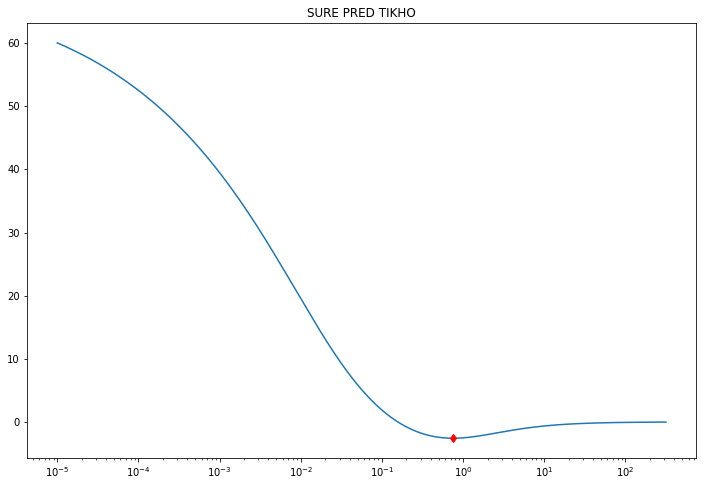

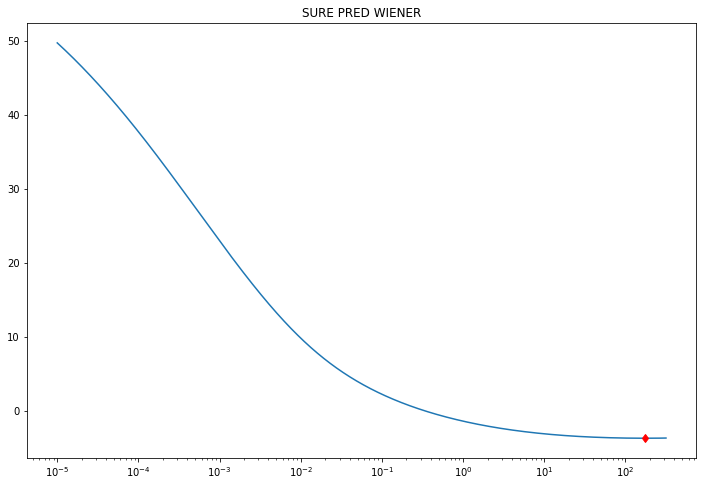

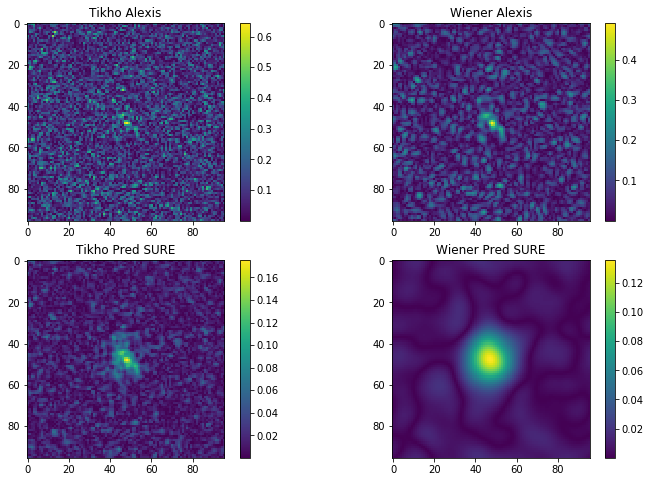

In [55]:
def pred_risk_est0(im_fft,h2,reg2,tau,sigma):
    wiener_f=h2/(h2+tau*reg2)
    res=np.sum(np.abs(im_fft*(1.0-wiener_f))**2)
    tr_res=-(sigma**2) * np.sum((1.0-wiener_f)**2)
    tr=(sigma**2) * np.sum((wiener_f)**2)
    return res+tr+tr_res

def pred_risk_est(im_fft,h2,reg2,tau,sigma):
    wiener_f=h2/(h2+tau*reg2)
    wiener_f2=wiener_f**2
    im_fft_2=np.abs(im_fft)**2
    t1=np.sum(wiener_f2 * im_fft_2)
    t2=2.0*(sigma**2) * np.sum(wiener_f)
    t3=-2* np.sum(wiener_f*np.abs(im_fft)**2)
    return t1+t2+t3


res_sure_pred_risk_tikho=np.array([[x,pred_risk_est(yf,h2,d2,x,sigma_list[0])] for x in check_hyper])
tau_sure_pred_tikho=res_sure_pred_risk_tikho[np.argmin(res_sure_pred_risk_tikho[:,1])][0]

res_sure_pred_risk_wiener=np.array([[x,pred_risk_est(yf,h2,l2,x,sigma_list[0])] for x in check_hyper])
tau_sure_pred_wiener=res_sure_pred_risk_wiener[np.argmin(res_sure_pred_risk_wiener[:,1])][0]

print(tau_sure_pred_tikho,tau_sure_pred_wiener,1/SNR_list[0],np.min(res_sure_pred_risk_wiener) )

plt.figure()
plt.plot(res_sure_pred_risk_tikho[:,0],res_sure_pred_risk_tikho[:,1]),plt.title("SURE PRED TIKHO")
plt.plot([tau_sure_pred_tikho],[res_sure_pred_risk_tikho[np.argmin(res_sure_pred_risk_tikho[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()
plt.plot(res_sure_pred_risk_wiener[:,0],res_sure_pred_risk_wiener[:,1]),plt.title("SURE PRED WIENER")
plt.plot([tau_sure_pred_wiener],[res_sure_pred_risk_wiener[np.argmin(res_sure_pred_risk_wiener[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()
skimage_sure_pred_tikho=restoration.wiener(noisy_im,trans_func,tau_sure_pred_tikho,reg=tfdirac, is_real=False,clip=False)
skimage_sure_pred_wiener=restoration.wiener(noisy_im,trans_func,tau_sure_pred_wiener,reg=lap_tf, is_real=False,clip=False)
plt.subplot(221),plt.imshow(np.abs(sol_tik)),plt.colorbar(),plt.title("Tikho Alexis")
plt.subplot(222),plt.imshow(np.abs(sol_wien)),plt.colorbar(),plt.title("Wiener Alexis")
plt.subplot(223),plt.imshow(np.abs(skimage_sure_pred_tikho)),plt.colorbar(),plt.title("Tikho Pred SURE")
plt.subplot(224),plt.imshow(np.abs(skimage_sure_pred_wiener)),plt.colorbar(),plt.title("Wiener Pred SURE")



### Generalized cross-validation

0.6486344335506385 
 159.58791472455718


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2ab2b81358>,
 Text(0.5, 1.0, 'Wiener GCV'))

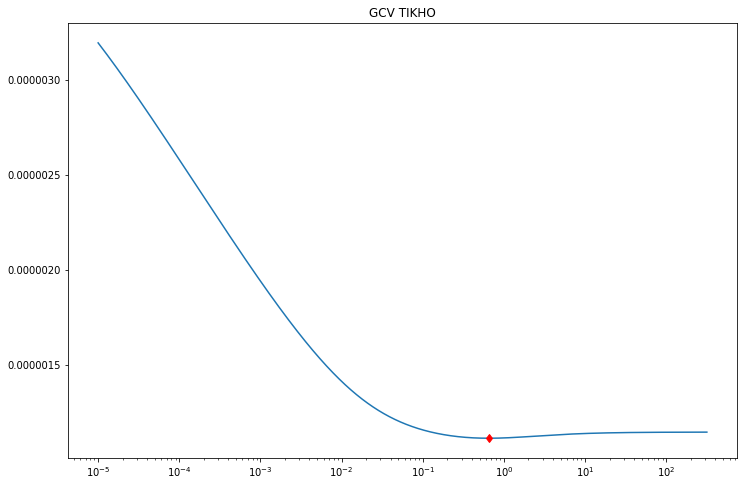

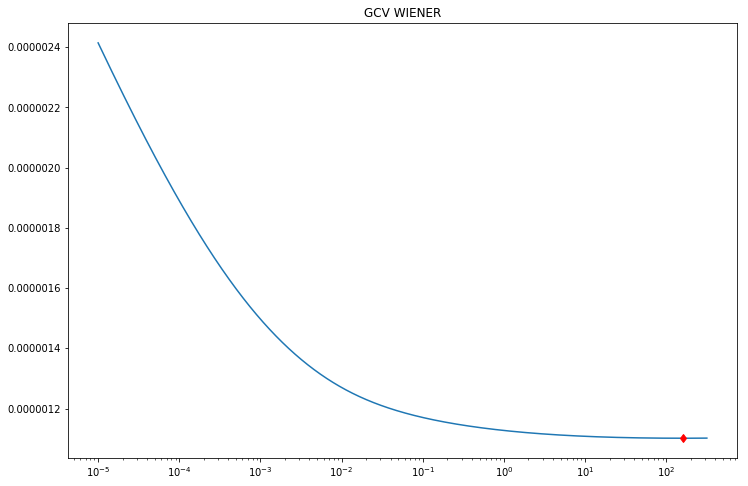

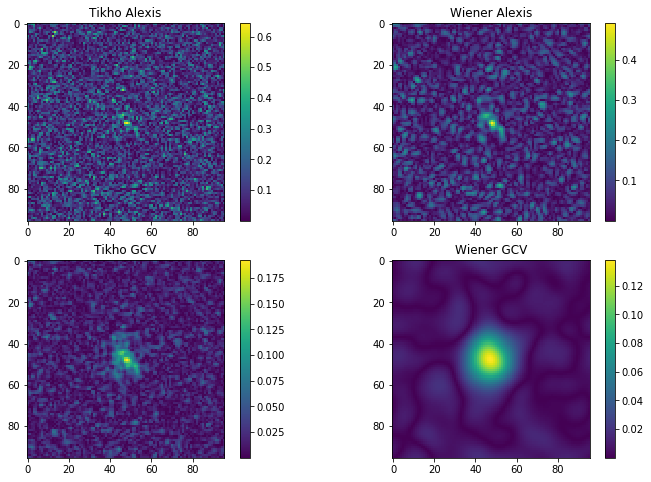

In [56]:
def gcv(im_fft,h2,reg2,tau):
    hfstar=np.conj(trans_func)
    wiener_f=h2/(h2+tau*reg2)
    res=np.sum(np.abs(im_fft)**2*(1.0-wiener_f)**2)
    tr=np.sum(1.0-wiener_f)**2
    return res/tr

res_gcv_tikho=np.array([[x,gcv(yf,h2,d2,x)] for x in check_hyper])
tau_tikho_gcv=res_gcv_tikho[np.argmin(res_gcv_tikho[:,1])][0]
res_gcv_wiener=np.array([[x,gcv(yf,h2,l2,x)] for x in check_hyper])
tau_wiener_gcv=res_gcv_wiener[np.argmin(res_gcv_wiener[:,1])][0]

print(tau_tikho_gcv,'\n',tau_wiener_gcv)

skimage_gcv_tikho=restoration.wiener(noisy_im,trans_func,tau_tikho_gcv,reg=tfdirac, is_real=False,clip=False)
skimage_gcv_wiener=restoration.wiener(noisy_im,trans_func,tau_wiener_gcv,reg=lap_tf, is_real=False,clip=False)

plt.figure()
plt.plot(res_gcv_tikho[:,0],res_gcv_tikho[:,1]),plt.title("GCV TIKHO")
plt.plot([tau_tikho_gcv],[res_gcv_tikho[np.argmin(res_gcv_tikho[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()
plt.plot(res_gcv_wiener[:,0],res_gcv_wiener[:,1]),plt.title("GCV WIENER")
plt.plot([tau_wiener_gcv],[res_gcv_wiener[np.argmin(res_gcv_wiener[:,1])][1]],'rd')
plt.xscale('log')
plt.figure()


plt.subplot(221),plt.imshow(np.abs(sol_tik)),plt.colorbar(),plt.title("Tikho Alexis")
plt.subplot(222),plt.imshow(np.abs(sol_wien)),plt.colorbar(),plt.title("Wiener Alexis")
plt.subplot(223),plt.imshow(np.abs(skimage_gcv_tikho)),plt.colorbar(),plt.title("Tikho GCV")
plt.subplot(224),plt.imshow(np.abs(skimage_gcv_wiener)),plt.colorbar(),plt.title("Wiener GCV")


### Now test Pereyra Bayesian approach

In [57]:
def lambda_pereyra(noisy_im,trans_func,tau0,sigma,reg,nit=10,alpha=1,beta=1):
    tau_list=[tau0]
    tau_cur=tau0
    sigma2=sigma**2
    h2=np.abs(trans_func)**2 #This is |h_w|^2
    reg2=np.abs(reg)**2 #This is |l_w|^2 in case of laplacian
    y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    for kit in range(nit):
        deconv0=restoration.wiener(noisy_im,trans_func,tau_cur*sigma2,reg=reg, is_real=False,clip=False)
        deconv_lap=restoration.uft.uifft2(reg*restoration.uft.ufft2(deconv0))
        tau_cur=(n_im/2.0 + alpha - 1.0)/(np.linalg.norm(deconv_lap,ord='fro')**2+beta)
        tau_list.append(tau_cur)
    return np.array(tau_list)*sigma2
 
def lambda_pereyra_fourier(noisy_im,trans_func,tau0,sigma,reg,nit=10,alpha=1,beta=1):
    tau_list=[tau0]
    tau_cur=tau0
    sigma2=sigma**2
    h2=np.abs(trans_func)**2 #This is |h_w|^2
    reg2=np.abs(reg)**2 #This is |l_w|^2 in case of laplacian
    y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    num_f=h2*reg2*y2
    for kit in range(nit):
        deconvf2=num_f/(h2+tau_cur*sigma2*reg2)**2
        tau_cur=(n_im/2.0 + alpha - 1.0)/(np.sum(deconvf2)+beta)
        tau_list.append(tau_cur)
    return np.array(tau_list)*sigma2
#Note: gamma prior implies$ mean=\alpha/\beta$, and $var=\alpha/(\beta^2)$  
#tau_pereyra_wiener=lambda_pereyra(noisy_im,trans_func,1/sigma_list[0]**2,sigma_list[0],lap_tf,nit=20,alpha=1,beta=1)
#tau_pereyra_wiener_fourier=lambda_pereyra_fourier(noisy_im,trans_func,1,sigma_list[0],lap_tf,nit=20,alpha=1,beta=1)

tau_pereyra_tikho=lambda_pereyra_fourier(noisy_im,trans_func,1,sigma_list[0],tfdirac,nit=20,alpha=1,beta=1)
tau_pereyra_wiener=lambda_pereyra_fourier(noisy_im,trans_func,1,sigma_list[0],lap_tf,nit=20,alpha=1,beta=1)


In [58]:
print('Tikho SNR :',SNR_list[0],'\n',"SURE PROJ=",tau_sure_proj_tikho,'\n',"SURE PRED=",tau_sure_pred_tikho,'\n',"GCV=",tau_tikho_gcv,'\n',"PEREYRA GAMMA=",tau_pereyra_tikho[-1],'\n\n')
print('Wiener SNR:',SNR_list[0],'\n',"SURE PROJ=",tau_sure_proj_wiener,'\n',"SURE PRED=",tau_sure_pred_wiener,'\n',"GCV=",tau_wiener_gcv,'\n',"PEREYRA GAMMA=",tau_pereyra_wiener[-1],'\n')


Tikho SNR : 20.0 
 SURE PROJ= 4.988844874621981 
 SURE PRED= 0.7516228940210237 
 GCV= 0.6486344335506385 
 PEREYRA GAMMA= 47.408643953151675 


Wiener SNR: 20.0 
 SURE PROJ= 168.65530253981137 
 SURE PRED= 174.18068734013127 
 GCV= 159.58791472455718 
 PEREYRA GAMMA= 46.96075963415518 



In [59]:
deconv_sure_proj_tikho=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_sure_proj_tikho)
deconv_sure_pred_tikho=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_sure_pred_tikho)
deconv_tikho_gcv=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_tikho_gcv)
deconv_tikho_per=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_pereyra_tikho[-1])

deconv_sure_proj_wiener=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_sure_proj_wiener)
deconv_sure_pred_wiener=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_sure_pred_wiener)
deconv_wiener_gcv=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_wiener_gcv)
deconv_wiener_per=manual_deconv_l2(noisy_im,trans_func,tfdirac,tau_pereyra_wiener[-1])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2ac013c898>,
 Text(0.5, 1.0, 'Pereyra Wiener'))

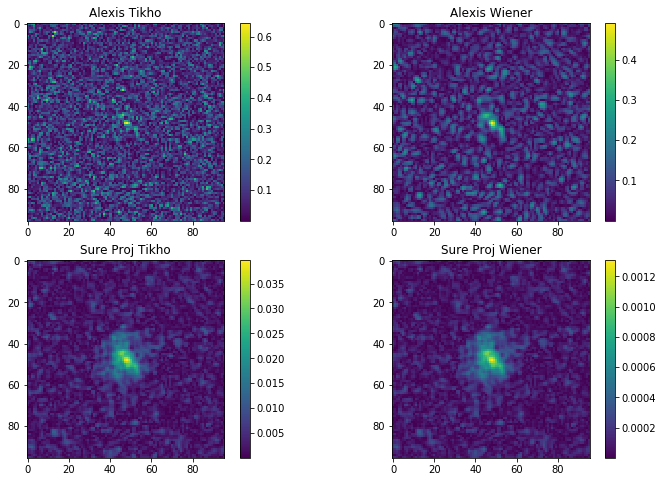

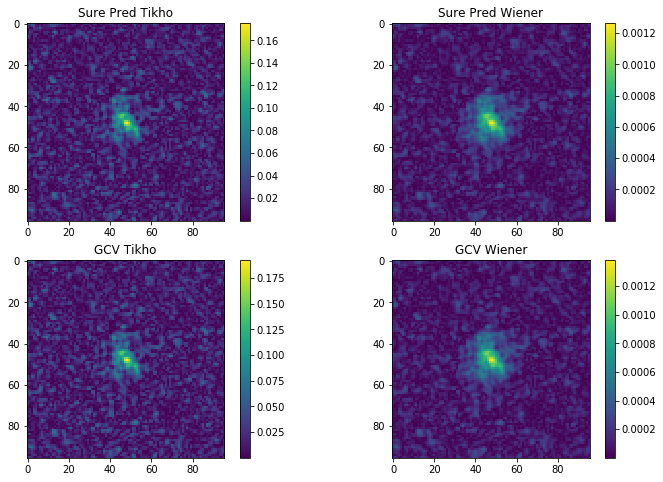

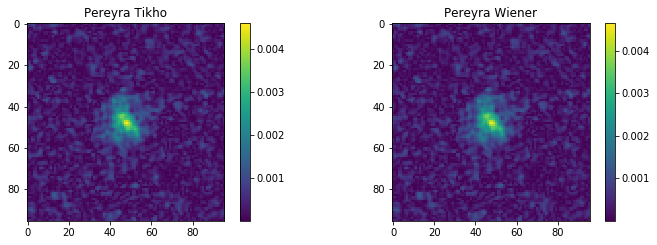

In [60]:
plt.figure()
plt.subplot(221),plt.imshow(np.abs(sol_tik)),plt.colorbar(),plt.title('Alexis Tikho')
plt.subplot(222),plt.imshow(np.abs(sol_wien)),plt.colorbar(),plt.title('Alexis Wiener')
plt.subplot(223),plt.imshow(np.abs(deconv_sure_proj_tikho)),plt.colorbar(),plt.title('Sure Proj Tikho')
plt.subplot(224),plt.imshow(np.abs(deconv_sure_proj_wiener)),plt.colorbar(),plt.title('Sure Proj Wiener')
plt.figure()
plt.subplot(221),plt.imshow(np.abs(deconv_sure_pred_tikho)),plt.colorbar(),plt.title('Sure Pred Tikho')
plt.subplot(222),plt.imshow(np.abs(deconv_sure_pred_wiener)),plt.colorbar(),plt.title('Sure Pred Wiener')
plt.subplot(223),plt.imshow(np.abs(deconv_tikho_gcv)),plt.colorbar(),plt.title('GCV Tikho')
plt.subplot(224),plt.imshow(np.abs(deconv_wiener_gcv)),plt.colorbar(),plt.title('GCV Wiener')
plt.figure()
plt.subplot(221),plt.imshow(np.abs(deconv_tikho_per)),plt.colorbar(),plt.title('Pereyra Tikho')
plt.subplot(222),plt.imshow(np.abs(deconv_wiener_per)),plt.colorbar(),plt.title('Pereyra Wiener')

